# Wordclouds for low, medium and high sentiment tweets

Currently only for 19VzlaEnLaCalle (2017/04/19 to 2017/04/22)

In [94]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#from stop_words import get_stop_words
from wordcloud import WordCloud 
from PIL import Image
from os import path, getcwd

import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Import and preprocess data

In [2]:
# The Sentiment Analysis API evaluates text input and returns a sentiment score for each document, 
# ranging from 0 (negative) to 1 (positive).
df = pd.read_csv('data/sentiment/19VzlaEnLaCalle_2017_04_19_to_2017_04_22_sent.csv')
df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,Somos el 95% de OPOSITORES el CNE lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895
1,1,desdevargas,2017-04-21 17:37,1,1,# 19VzlaEnLaCalle y en los puntos rojos de Var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140
2,2,incesamazonas,2017-04-21 16:38,0,0,Retweeted ANTV VENEZUELA (@ANTV_VENEZUELA): # ...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037
3,3,incesamazonas,2017-04-21 16:28,0,0,Retweeted Elias Jaua ( @ JauaMiranda): # 19vzl...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,Retweeted Mando Militar ( @ MandoMilitar): # 1...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838


In [3]:
print(df['text'].iloc[92])
print(df['clean_text'].iloc[92])

RT @: 10:37AM Sujetos desconocidos arrojaron bombas lacrimógenas a manifestantes en San Bernardino # 19Abril # 19VzlaEnLaCalle ...
RT    10 37AM Sujetos desconocidos arrojaron bombas lacrimógenas a manifestantes en San Bernardino      


In [ ]:
# Sample of tweets
#df_sample = df[:100]
#tweets = " ".join(tweet for tweet in df.text)

len(df)

### Clean data, mostly similar to cleaning in tweet_visualizations.ipynb

In [4]:
# Change accented to plain text
def remove_accents(df):
    df = re.sub(r'é', 'e', df)
    df = re.sub(r'á', 'a', df)
    df = re.sub(r'ó', 'o', df)
    df = re.sub(r'í', 'i', df)
    df = re.sub(r'ñ', 'n', df)
    df = re.sub(r'ú', 'u', df)
    return df

df['clean_text_noaccents'] = df['clean_text'].apply(remove_accents)
df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,clean_text_noaccents
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,Somos el 95% de OPOSITORES el CNE lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,Somos el 95 de OPOSITORES el CNE lo q tiene q...
1,1,desdevargas,2017-04-21 17:37,1,1,# 19VzlaEnLaCalle y en los puntos rojos de Var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,y en los puntos rojos de Vargas en defensa de...
2,2,incesamazonas,2017-04-21 16:38,0,0,Retweeted ANTV VENEZUELA (@ANTV_VENEZUELA): # ...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,El el Pueblo con paz toma Caracas y
3,3,incesamazonas,2017-04-21 16:28,0,0,Retweeted Elias Jaua ( @ JauaMiranda): # 19vzl...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,logro el triunfo de la Independencia y La Pa...
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,Retweeted Mando Militar ( @ MandoMilitar): # 1...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,Momento cuando las personas son obligadas a ...


In [16]:
print(df['clean_text'].iloc[92])
print(df['clean_text_noaccents'].iloc[92])

RT    10 37AM Sujetos desconocidos arrojaron bombas lacrimógenas a manifestantes en San Bernardino      
RT    10 37AM Sujetos desconocidos arrojaron bombas lacrimogenas a manifestantes en San Bernardino      


In [20]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"pic.twitter.com\S+", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df


df_standardized = standardize_text(df,"clean_text_noaccents")

#cleanreviews.to_csv("cleanreviews_NYC.csv")
df_standardized.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,clean_text_noaccents
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,somos el 95 de opositores el cne lo q tiene q...
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,y en los puntos rojos de vargas en defensa de...
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,el el pueblo con paz toma caracas y
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,logro el triunfo de la independencia y la pa...
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,momento cuando las personas son obligadas a ...


In [21]:
print(df['clean_text'].iloc[92])
print(df['clean_text_noaccents'].iloc[92])

RT    10 37AM Sujetos desconocidos arrojaron bombas lacrimógenas a manifestantes en San Bernardino      
rt    10 37am sujetos desconocidos arrojaron bombas lacrimogenas a manifestantes en san bernardino      


In [ ]:
#Don't run: integrated in 'standardize_text' function above
#def clean_pictwit(df):
#    df = re.sub("pictwitter\w*", '', df)
#    return df
#    
#df['text_nopictwit'] = df['text'].apply(clean_pictwit)
#df.head()

In [ ]:
# Just a check if columns are similar
#indices = df.loc[df['text'] != df['text_nopictwit']]
#indices   # no differences if empty

### Tokenize

In [22]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')   # separate sentences into different words

df["tokens"] = df['clean_text_noaccents'].apply(tokenizer.tokenize)
#df.head()

In [23]:
print(df['clean_text_noaccents'].iloc[92])
print(df['tokens'].iloc[92])

rt    10 37am sujetos desconocidos arrojaron bombas lacrimogenas a manifestantes en san bernardino      
['rt', '10', '37am', 'sujetos', 'desconocidos', 'arrojaron', 'bombas', 'lacrimogenas', 'a', 'manifestantes', 'en', 'san', 'bernardino']


### Remove stop words

In [24]:
# Get stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mspronk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['nostop'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop])

In [28]:
# Example after removing stopwords
print(df['tokens'].iloc[92])
print(df['nostop'].iloc[92])

['rt', '10', '37am', 'sujetos', 'desconocidos', 'arrojaron', 'bombas', 'lacrimogenas', 'a', 'manifestantes', 'en', 'san', 'bernardino']
['rt', '10', '37am', 'sujetos', 'desconocidos', 'arrojaron', 'bombas', 'lacrimogenas', 'manifestantes', 'san', 'bernardino']


### Lemmatization

In [30]:
# Lemmatization (return "base" of words)
print(" ".join(SnowballStemmer.languages))


#nltk.download('wordnet')
#lemmatizer = WordNetLemmatizer()

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [31]:
stemmer = SnowballStemmer("spanish")
#stemmer.stem("Autobahnen")   #example German

In [32]:
def stem_text(text):
    return [stemmer.stem(x) for x in text]

df['stems'] = df['nostop'].apply(stem_text)

In [33]:
# Example after removing stopwords
print(df['nostop'].iloc[92])
print(df['stems'].iloc[92])   # I guess we don't want to use stemming

['rt', '10', '37am', 'sujetos', 'desconocidos', 'arrojaron', 'bombas', 'lacrimogenas', 'manifestantes', 'san', 'bernardino']
['rt', '10', '37am', 'sujet', 'desconoc', 'arroj', 'bomb', 'lacrimogen', 'manifest', 'san', 'bernardin']


In [34]:
df['language'].unique()

array(['es', 'en', 'pt', 'gl', 'fr', 'hu', 'de', 'cs', 'ar', 'it', 'nl',
       'hr', 'ms', 'fi'], dtype=object)

In [35]:
df_es = df[df['language']=='es']
len(df_es)

20246

## Wordclouds

In [36]:
#Wordcloud for all tweets
all_tweets = df_es['nostop'].tolist()

def flatten(inputdata):
    flat_list = [item for sublist in inputdata for item in sublist]
    return flat_list

all_tweets_onelist = flatten(all_tweets)
#all_tweets_onelist

In [90]:
def make_wordcloud(list):
    wc=WordCloud(min_font_size = 8, max_font_size=100, mask=my_mask,
                      max_words=200,colormap="Reds", contour_width = 1, 
                      contour_color = "Red",collocations = False,
                      background_color="white").generate(' '.join(list))
    return wc

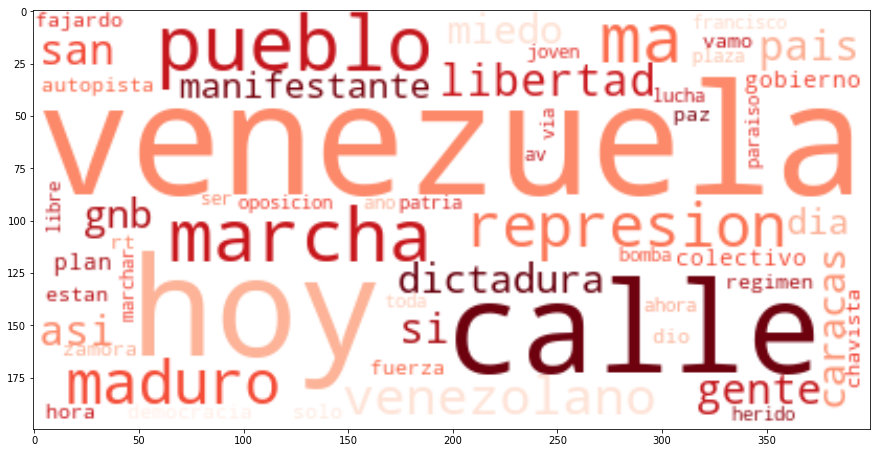

In [38]:
wc = make_wordcloud(all_tweets_onelist)
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')

## Wordcloud low sentiment

In [39]:
def flatten(inputdata):
    flat_list = [item for sublist in inputdata for item in sublist]
    return flat_list

In [40]:
# Same, but for low sentiment tweets
df_lowsent = df_es[df_es['sentiment']<.20]
print(len(df_lowsent))
   
# Convert to list for input in wordcloud    
tweets_lowsent = df_lowsent['nostop'].tolist()

tweets_lowsent_list = flatten(tweets_lowsent)

1880


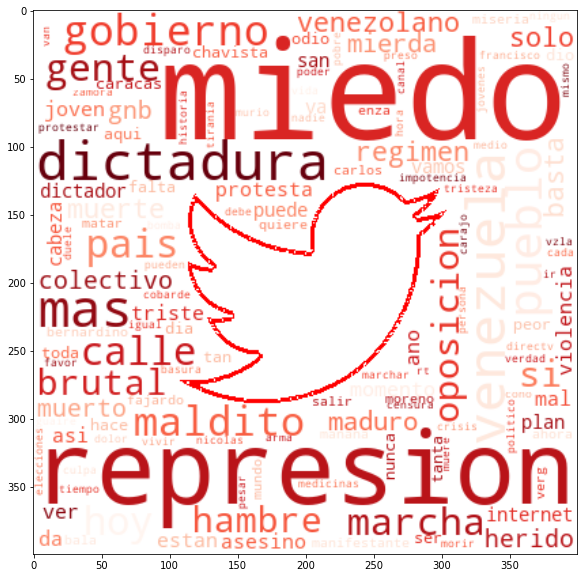

In [101]:
d = getcwd()
twitter_mask = np.array(Image.open(path.join(d, "twittermask.png")))
my_mask = twitter_mask
wc_lowsent = make_wordcloud(tweets_lowsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_lowsent, interpolation='bilinear')
wc_lowsent.to_file('low_sentiment_19VzlaEnLaCalle.png')

## Wordcloud high sentiment

In [42]:
# Same, but for high sentiment tweets
df_highsent = df_es[df_es['sentiment']>.80]
print(len(df_highsent))
   
# Convert to list for input in wordcloud    
tweets_highsent = df_highsent['nostop'].tolist()

tweets_highsent_list = flatten(tweets_highsent)

2002


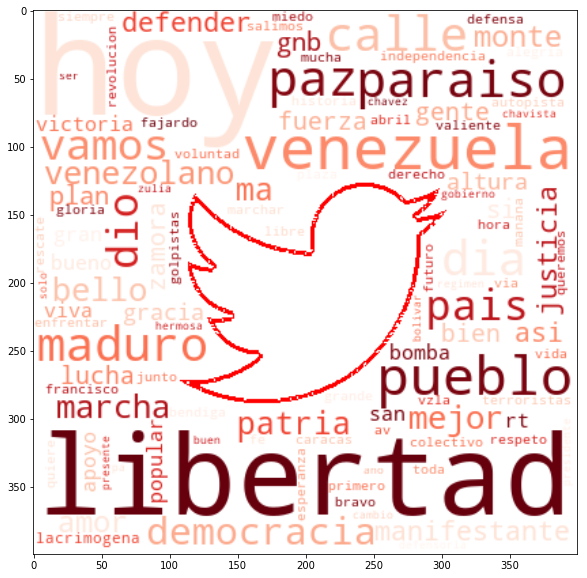

In [103]:
d = getcwd()
twitter_mask = np.array(Image.open(path.join(d, "twittermask.png")))
my_mask = twitter_mask
wc_highsent = make_wordcloud(tweets_highsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_highsent, interpolation='bilinear')
wc_highsent.to_file('high_sentiment_19VzlaEnLaCalle.png')

## Wordcloud medium sentiment

In [49]:
# Same, but for high sentiment tweets
df_mediumsent = df_es[(df_es['sentiment']>.40) & (df_es['sentiment']<.60)]
print(len(df_mediumsent))
   

8277


In [50]:
# Convert to list for input in wordcloud    
tweets_mediumsent = df_mediumsent['nostop'].tolist()

tweets_mediumsent_list = flatten(tweets_mediumsent)

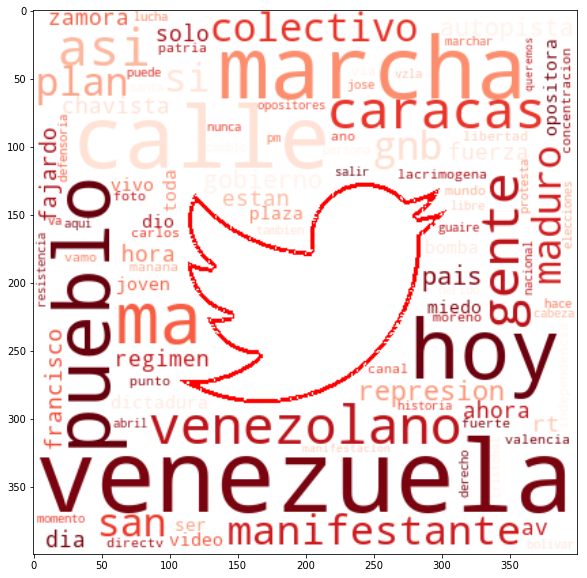

In [104]:
d = getcwd()
twitter_mask = np.array(Image.open(path.join(d, "twittermask.png")))
my_mask = twitter_mask
wc_mediumsent = make_wordcloud(tweets_mediumsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_mediumsent, interpolation='bilinear')
wc_mediumsent.to_file('medium_sentiment_19VzlaEnLaCalle.png')

In [ ]:
# Remove the protest hashtag from lists  --> already done in clean_text that was used to make nostop column, so not necessary.
#hashtag = '19vzlaenlacalle'
#tweets_lowsent_nohashtag = [word for word in tweets_lowsent_list if word not in hashtag]
#tweets_highsent_nohashtag = [word for word in tweets_highsent_list if word not in hashtag]
#tweets_mediumsent_nohashtag = [word for word in tweets_mediumsent_list if word not in hashtag]

#### Wordclouds without hashtag (not necesasary in this new notebook version)

In [ ]:
# Wordcloud low sentiment, no hashtag
#wc_lowsent_nh = make_wordcloud(tweets_lowsent)
#plt.figure(figsize=(15,10))
#plt.title('Low Sentiment', fontsize=20)
#plt.imshow(wc_lowsent_nh, interpolation='bilinear')

In [ ]:
# Wordcloud low sentiment, no hashtag
#wc_highsent_nh = make_wordcloud(tweets)
#plt.figure(figsize=(15,10))
#plt.title('High Sentiment', fontsize=20)
#plt.imshow(wc_highsent_nh, interpolation='bilinear')

In [ ]:
# Wordcloud medium sentiment, no hashtag
#wc_mediumsent_nh = make_wordcloud(tweets_mediumsent)
#plt.figure(figsize=(15,10))
#plt.title('Medium Sentiment', fontsize=20)
#plt.imshow(wc_mediumsent_nh, interpolation='bilinear')

## Sentiment and number of retweets

In [52]:
df_es.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,clean_text_noaccents,tokens,nostop,stems
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,somos el 95 de opositores el cne lo q tiene q...,"[somos, el, 95, de, opositores, el, cne, lo, q...","[95, opositores, cne, q, q, redactar, credenci...","[95, opositor, cne, q, q, redact, credencial, ..."
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,y en los puntos rojos de vargas en defensa de...,"[y, en, los, puntos, rojos, de, vargas, en, de...","[puntos, rojos, vargas, defensa, revolucion, p...","[punt, roj, varg, defens, revolucion, period, 4f]"
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,el el pueblo con paz toma caracas y,"[el, el, pueblo, con, paz, toma, caracas, y]","[pueblo, paz, toma, caracas]","[puebl, paz, tom, carac]"
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,logro el triunfo de la independencia y la pa...,"[logro, el, triunfo, de, la, independencia, y,...","[logro, triunfo, independencia, paz, dia]","[logr, triunf, independent, paz, dia]"
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,momento cuando las personas son obligadas a ...,"[momento, cuando, las, personas, son, obligada...","[momento, personas, obligadas, cruzar]","[moment, person, oblig, cruz]"


## Relation between sentiment and number of retweets?

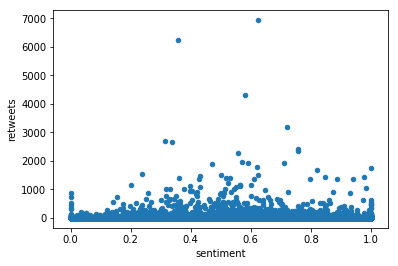

In [53]:
df_es.plot(kind='scatter', x='sentiment', y='retweets')

In [54]:
correlation = df_es['sentiment'].corr(df_es['retweets'])   # Pearson correlation
print(correlation)

0.018629527322001287


## Sentiment and retweets over time

In [55]:
df_es['date'] = pd.to_datetime(df_es['date'], errors='coerce')

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
df_es = df_es.set_index(pd.DatetimeIndex(df_es['date']))

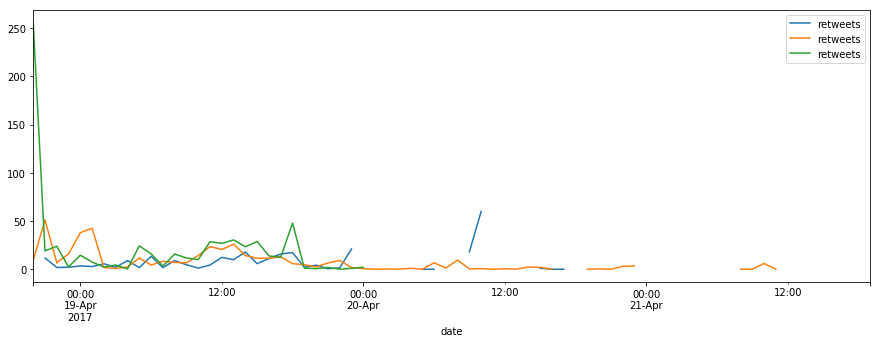

In [58]:
df_lowsent = df_es[df_es['sentiment']<.20]
df_lowsent = df_lowsent.set_index(pd.DatetimeIndex(df_lowsent['date']))
df_lowsent = df_lowsent.resample('H').mean()
#df_lowsent.plot( y=['sentiment'], figsize=(10,5))

df_highsent = df_es[df_es['sentiment']>.80]
df_highsent = df_highsent.set_index(pd.DatetimeIndex(df_highsent['date']))
df_highsent = df_highsent.resample('H').mean()
#df_highsent.plot( y=['sentiment'], figsize=(10,5))

df_mediumsent = df_es[(df_es['sentiment']>.40) & (df_es['sentiment']<.60)]
df_mediumsent = df_mediumsent.set_index(pd.DatetimeIndex(df_mediumsent['date']))
df_mediumsent = df_mediumsent.resample('H').mean()

ax = df_lowsent.plot(y=['retweets'], figsize=(15,5))   # blue
df_mediumsent.plot(ax=ax, y=['retweets'])   # orange
df_highsent.plot(ax=ax, y=['retweets'])   # green 

## Low sentiment vectors

In [62]:
df_lowsent = df_es[df_es['sentiment']<.20]
df_lowsent.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,clean_text_noaccents,tokens,nostop,stems
date,,,,,,,,,,,,,,,,,,,
2017-04-21 10:10:00,9,notihoyweb,2017-04-21 10:10:00,0,0,claves para entender la crisis pol tica en ven...,NaN,NaN,#,8.554235e+17,https://twitter.com/notihoyweb/status/85542345...,Claves para entender la crisis política en Ven...,Claves para entender la crisis política en Ven...,es,0.182675,claves para entender la crisis politica en ven...,"[claves, para, entender, la, crisis, politica,...","[claves, entender, crisis, politica, venezuela]","[clav, entend, crisis, polit, venezuel]"
2017-04-20 22:43:00,23,obdulio69,2017-04-20 22:43:00,0,0,19vzlaenlacalle que desgracia este gobierno ...,NaN,NaN,#,8.552505e+17,https://twitter.com/obdulio69/status/855250544...,# 19VzlaEnLaCalle que desgracia este gobierno....,que desgracia este gobierno Ya ni trabajar se...,es,0.065217,que desgracia este gobierno ya ni trabajar se...,"[que, desgracia, este, gobierno, ya, ni, traba...","[desgracia, gobierno, trabajar, puede, gente, ...","[desgraci, gobiern, trabaj, pued, gent, mied, ..."
2017-04-20 17:15:00,49,VenezuelHabla,2017-04-20 17:15:00,0,0,aragua venezuela militares disparando al blanc...,NaN,@,# # #,8.551680e+17,https://twitter.com/VenezuelHabla/status/85516...,Aragua Venezuela Militares disparando al blanc...,Aragua Venezuela Militares disparando al blanc...,es,0.179029,aragua venezuela militares disparando al blanc...,"[aragua, venezuela, militares, disparando, al,...","[aragua, venezuela, militares, disparando, bla...","[aragu, venezuel, militar, dispar, blanc, mat]"
2017-04-20 16:05:00,57,notihoyweb,2017-04-20 16:05:00,0,0,claves para entender la crisis pol tica en ven...,NaN,NaN,#,8.551504e+17,https://twitter.com/notihoyweb/status/85515035...,Claves para entender la crisis política en Ven...,Claves para entender la crisis política en Ven...,es,0.182675,claves para entender la crisis politica en ven...,"[claves, para, entender, la, crisis, politica,...","[claves, entender, crisis, politica, venezuela]","[clav, entend, crisis, polit, venezuel]"
2017-04-20 15:29:00,60,Monik2714,2017-04-20 15:29:00,1,1,"19vzlaenlacalle tiene basura, corotos, trato...",NaN,NaN,#,8.551414e+17,https://twitter.com/Monik2714/status/855141439...,"# 19VzlaEnLaCalle TIENE BASURA, COROTOS, TRATO...",TIENE BASURA COROTOS TRATOS VIEJOS PÓNGALO ...,es,0.128618,tiene basura corotos tratos viejos p ngalo ...,"[tiene, basura, corotos, tratos, viejos, p, ng...","[basura, corotos, tratos, viejos, p, ngalo, ca...","[basur, corot, trat, viej, p, ngal, call, tran..."


In [64]:
tweets_lowsent_doc = df_lowsent['nostop'].tolist()

In [65]:
# Continuous Bag of Words (CBOW) model (predict word from context)
model1 = Word2Vec(tweets_lowsent_doc, size=100, window=5, min_count=3, workers=4)

In [66]:
# Train model
model1.train(tweets_lowsent_doc, total_examples=len(tweets_lowsent_doc), epochs=10)

(101413, 159440)

In [67]:
len(tweets_lowsent_doc)

1880

In [68]:
# Save model
#model1.save("low_sentiment.model")

In [69]:
# Get vectors
lowsent_vectors = model1.wv

In [70]:
# Fit a 2D PCA model to the vectors
X_1 = model1[model1.wv.vocab]
pca_1 = PCA(n_components=2)
result1 = pca_1.fit_transform(X_1)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1104


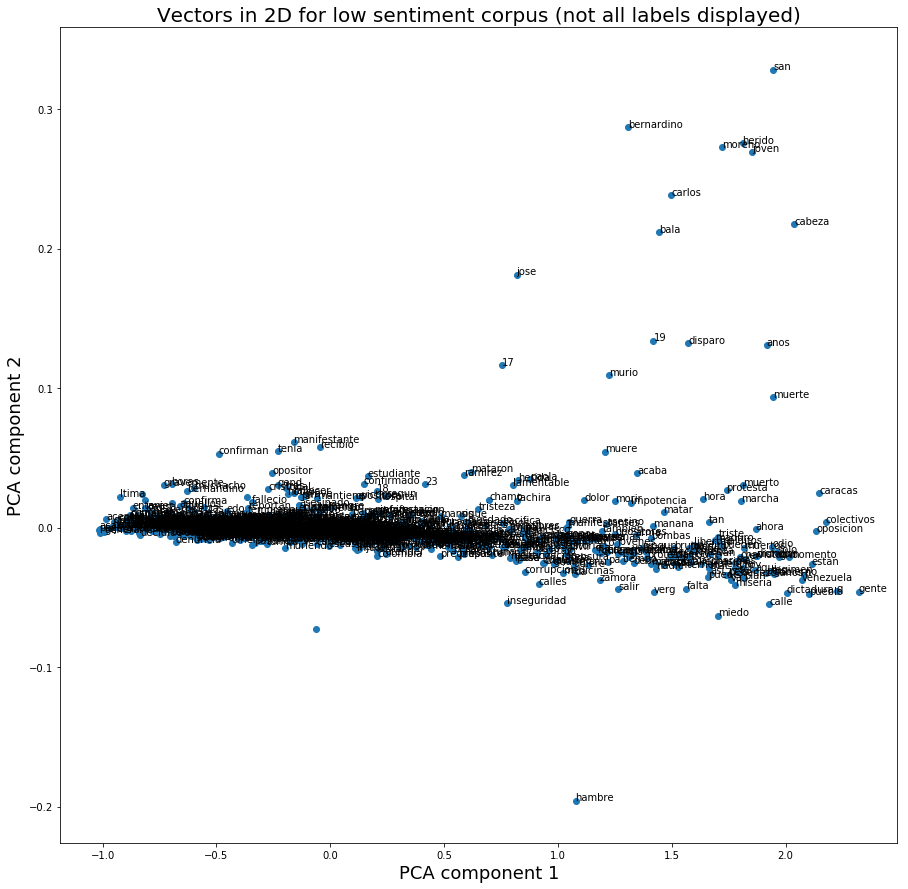

In [71]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result1[:, 0], result1[:, 1])
words = list(model1.wv.vocab)
print(len(words))
words_part = words[0:1000]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result1[i, 0], result1[i, 1]))
plt.title('Vectors in 2D for low sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()


## High sentiment vectors

In [74]:
df_highsent = df_es[df_es['sentiment']>.80]
tweets_highsent_doc = df_highsent['nostop'].tolist()

# Continuous Bag of Words (CBOW) model (predict word from context)
model2 = Word2Vec(tweets_highsent_doc, size=100, window=5, min_count=3, workers=4)

# Train model
model2.train(tweets_highsent_doc, total_examples=len(tweets_highsent_doc), epochs=10)

# Save model
#model2.save("high_sentiment.model")

# Get vectors
highsent_vectors = model2.wv

In [75]:
# Fit a 2D PCA model to the vectors
X_2 = model2[model2.wv.vocab]
pca_2 = PCA(n_components=2)
result2 = pca_2.fit_transform(X_2)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


955


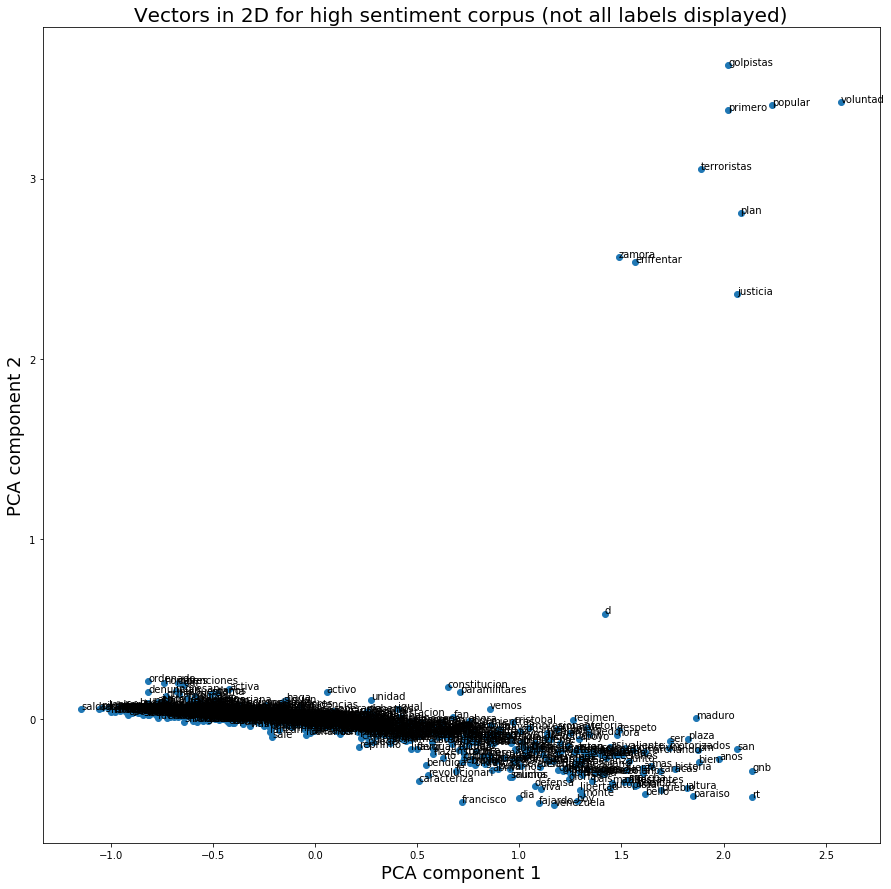

In [76]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result2[:, 0], result2[:, 1])
words = list(model2.wv.vocab)
print(len(words))
words_part = words[0:1000]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.title('Vectors in 2D for high sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()

## Medium sentiment vectors

In [78]:
df_mediumsent = df_es[(df_es['sentiment']>.40) & (df_es['sentiment']<.60)]
tweets_mediumsent_doc = df_mediumsent['nostop'].tolist()

# Continuous Bag of Words (CBOW) model (predict word from context)
model3 = Word2Vec(tweets_mediumsent_doc, size=100, window=5, min_count=3, workers=4)

# Train model
model3.train(tweets_mediumsent_doc, total_examples=len(tweets_mediumsent_doc), epochs=10)

# Save model
#model3.save("medium_sentiment.model")

# Get vectors
mediumsent_vectors = model3.wv

In [79]:
# Fit a 2D PCA model to the vectors
X_3 = model3[model3.wv.vocab]
pca_3 = PCA(n_components=2)
result3 = pca_3.fit_transform(X_3)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


2772


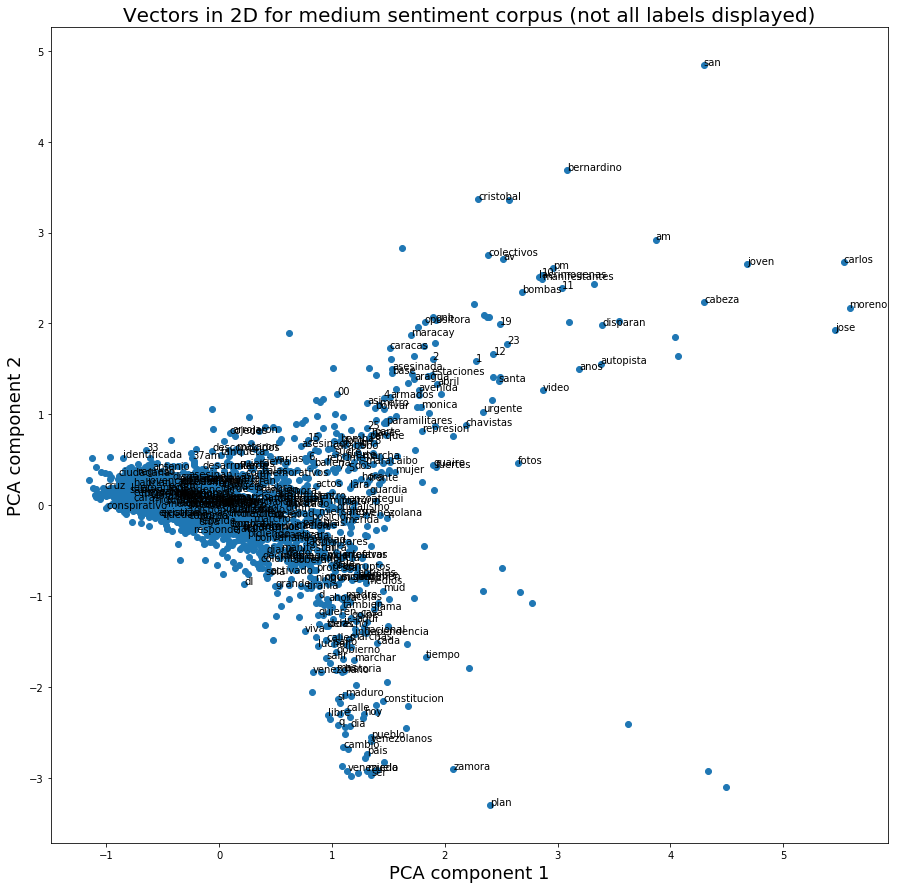

In [80]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result3[:, 0], result3[:, 1])
words = list(model3.wv.vocab)
print(len(words))
words_part = words[0:300]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result3[i, 0], result3[i, 1]))
plt.title('Vectors in 2D for medium sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()

## Compare models

In [105]:
# Words most similar to 'fear' in low sentiment corpus
w1 = "miedo"   # fear
model1.wv.most_similar(positive=w1)

[('calle', 0.999772310256958),
 ('q', 0.9997718334197998),
 ('si', 0.999762773513794),
 ('regimen', 0.999755859375),
 ('venezuela', 0.9997545480728149),
 ('aqui', 0.9997529983520508),
 ('protestar', 0.9997504949569702),
 ('dictador', 0.999748706817627),
 ('puede', 0.9997479915618896),
 ('gente', 0.9997467994689941)]

In [82]:
# Words most similar to 'fear' in high sentiment corpus
model2.wv.most_similar(positive=w1)

[('manana', 0.9997232556343079),
 ('exigiendo', 0.9996363520622253),
 ('vez', 0.9996272921562195),
 ('ser', 0.9996249675750732),
 ('llego', 0.9996049404144287),
 ('apoyo', 0.9995972514152527),
 ('s', 0.9995850324630737),
 ('nuevo', 0.9995831251144409),
 ('poder', 0.9995566606521606),
 ('fin', 0.9995527267456055)]

In [83]:
# Words most similar to 'fear' in medium sentiment corpus
model3.wv.most_similar(positive=w1)

[('peleando', 0.9810237288475037),
 ('calle', 0.9807528257369995),
 ('pueblo', 0.9764703512191772),
 ('libertad', 0.9756976962089539),
 ('salio', 0.9692677855491638),
 ('quiere', 0.964626669883728),
 ('salir', 0.9616800546646118),
 ('cambio', 0.9612261056900024),
 ('dictadura', 0.9610978364944458),
 ('queremos', 0.9567933082580566)]